## Installation and Use

### Contents
1. [Import Packages](#Import-Packages)
2. [Metric](#Metric)
3. [ODB Observations](#ODB-Observations)
4. [QC Plans](#QC-Plans)
5. [Greedy-Max Plans](#Greedy-Max-Plans)

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import dates

In [2]:
import logging
import xml.etree.cElementTree as ElementTree
from zipfile import ZipFile 
import pickle

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.table import Table, vstack
from astropy.visualization import time_support
time_support()

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x7fd0a9575790>

In [4]:
import time
import pytz

In [5]:
import os
import copy
from importlib import reload

In [6]:
import vskyutil as vs
import sb as sb
import odbutils
import qpt
from get_tadata import get_report, get_tas, sumtas_date
from queue_metric import metric_slope, plotmetric_slope
import greedymax

In [7]:
from conditions import cond_match, windconditions

## Metric

In [8]:
# params9 - Parabolic Metric 2
params9 = {'1': {'m1': 1.406, 'b1': 2.0, 'm2': 0.50, 'b2': 0.5, 'xb': 0.8, 'xb0': 0.0, 'xc0': 0.0},
          '2': {'m1': 1.406, 'b1': 1.0, 'm2': 0.50, 'b2': 0.5, 'xb': 0.8, 'xb0': 0.0, 'xc0': 0.0},
          '3': {'m1': 1.406, 'b1': 0.0, 'm2': 0.50, 'b2': 0.5, 'xb': 0.8, 'xb0': 0.0, 'xc0': 0.0},
          '4': {'m1': 0.00, 'b1': 0.1, 'm2': 0.00, 'b2': 0.0, 'xb': 0.8, 'xb0': 0.0, 'xc0': 0.0},
          }

In [9]:
# m2 = {'3': 0.5, '2': 3.0, '1':10.0} # use with b1*r where r=3
m2 = {'4': 0.0, '3': 1.0, '2': 6.0, '1':20.0} # use with b1 + 5.
xb = 0.8
r = 3.0
# b1 = np.array([6.0, 1.0, 0.2])
b1 = 1.2
for band in ['3', '2', '1']:
#     b2 = b1*r - m2[band]
    # intercept for linear segment
    b2 = b1 + 5. - m2[band]
    # parabola coefficient so that the curves meet at xb: y = m1*xb**2 + b1 = m2*xb + b2
    m1 = (m2[band]*xb + b2)/xb**2
    params9[band]['m1'] = m1
    params9[band]['m2'] = m2[band]
    params9[band]['b1'] = b1
    params9[band]['b2'] = b2
    params9[band]['xb'] = xb
    # zeropoint for band separation
    b1 += m2[band]*1.0 + b2

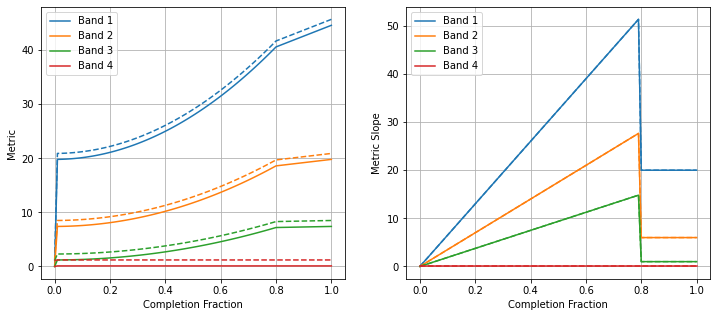

In [10]:
plotmetric_slope(params9, pow=2, thesis_factor=1.1)

## ODB Observations

In [11]:
# Configuration
# Select site
site_name = 'gs'
#site_name = 'gn'

# Root directory for files 
rootdir = '/Users/stroncoso/Code/sciops/otxmls/'

# Create needed directories if they do not exist
if not os.path.exists(rootdir):
    os.makedirs(rootdir)

if not os.path.exists(rootdir + '/nightplans'):
    os.makedirs(rootdir + '/nightplans')

# Location for storing ephemeris files - these can be used on multiple nights
ephemdir = rootdir + '/ephem/'
if not os.path.exists(ephemdir):
    os.makedirs(ephemdir)

In [12]:
# Inclusive date range for visibility calculations
# The start date should be the UT date for the desired plan
time_range = Time(["2019-02-02 08:00:00", "2019-05-01 08:00:00"], format='iso', scale='utc')

# The semesters to consider for the plan
semesters = ['2018B','2019A']

In [13]:
# Site details
if site_name == 'gn':
    site = EarthLocation.of_site('gemini_north')
    hst = pytz.timezone(site.info.meta['timezone'])
elif site_name == 'gs':
    site = EarthLocation.of_site('gemini_south')
    clt = pytz.timezone(site.info.meta['timezone'])
else:
    print('ERROR: site_name must be "gs" or "gn".')
site.info.meta['name'] = site_name
utc = pytz.timezone('UTC')

In [14]:
# Get time used from tas (Time Accounting Summary) ODB report files

# Get time accounting from the day before the plan
# Plan date
date = time_range[0].strftime('%Y%m%d')

# Date for time accounting
tadate = (time_range[0] - 1.0*u.day).strftime('%Y%m%d')

# Upper-case site string
ssite = site.info.meta['name'].upper()
print(semesters, date, tadate)

# Make directory for the files related to this plan
plandir = rootdir + '/nightplans/' + date + '/'
print(plandir)
if not os.path.exists(plandir):
    os.makedirs(plandir)
    
tas = Table()
for sem in semesters:
    tafile = 'tas_' + ssite + '_' + sem + '.txt'
    if not os.path.exists(plandir + tafile):
        get_report(ssite, tafile, plandir)
    
    tmp = get_tas(plandir + tafile)
    if tas:
        tas = vstack([tas, tmp])
    else:
        tas = tmp.copy()
        
progta = sumtas_date(tas, tadate)

['2018B', '2019A'] 20190202 20190201
/Users/stroncoso/Code/sciops/otxmls//nightplans/20190202/


In [15]:
reload(odbutils)

<module 'odbutils' from '/Users/stroncoso/Code/scheduler/greedy_max/odbutils.py'>

In [16]:
# Load programs by reading the ODB zip file directly

# To save space, access the ODB backup files from their native locations
# This requires running the process on a machine that can access these directories, this
# does not appear to work over VPN (and that would be very slow).
# Otherwise, copy the needed zip file to the local machine and define zipdir, e.g.
# zipdir = plandir
# Note that these files are about 1GB in size.
# if ssite == 'GS':
#     zipdir = '/net/sbfstonfs-nv1/tier1/odb/home/odbhome/ugemini/spdb/spdb.archive/archive/'
# else:
#     zipdir = '/net/hbf-nfs/sci/odb_backup/software/ugemini/spdb/spdb.archive/archive/'
# zipdir = rootdir + '/ghostqc/'
zipdir = rootdir

sitezip = {'GN': '-0715.zip', 'GS': '-0830.zip'}
zipfile = tadate + sitezip[ssite]
print(zipfile, zipfile[0:zipfile.rfind('.')])

# Define program types to select from
progtype = ['Q', 'LP', 'FT', 'DD']
xmlselect = []
for sem in semesters:
    for ptype in progtype:
        xmlselect.append(ssite + '-' + sem + '-' + ptype )
        
# xmlselect = ['GS-2018B-Q', 'GS-2018B-DD', 'GS-2018B-LP', 'GS-2018B-FT',
#             'GS-2019A-Q', 'GS-2019A-DD', 'GS-2019A-LP', 'GS-2019A-FT',]
# xmlselect = ['GN-2020B-Q']
print(xmlselect)

# selection = ['ONGOING', 'READY', 'INACTIVE']
obsclasses = ['SCIENCE', 'PROG_CAL', 'PARTNER_CAL']

tstart = time.time()
database = odbutils.readzip(zipdir + zipfile, xmlselect, tas=progta, obsclasses=obsclasses, 
                            sites=[site], time_range=time_range, ephemdir=ephemdir)
print(time.time() - tstart)

# print(names)
nobs_orig = database.nobs
nprog_orig = len(database.programs.keys())
print('Added ', database.nobs, ' observations from ', len(database.programs.keys()), ' programs.')

20190201-0715.zip 20190201-0715
['GN-2018B-Q', 'GN-2018B-LP', 'GN-2018B-FT', 'GN-2018B-DD', 'GN-2019A-Q', 'GN-2019A-LP', 'GN-2019A-FT', 'GN-2019A-DD']
['CheckStatus', 'ComputeTwilight', 'ConfigureLogging', 'ConvertWindows', 'CountObs', 'ElementTree', 'FindSite', 'GetAO', 'GetAffiliate', 'GetAllPars', 'GetAllTargets', 'GetAltairConfig', 'GetAwardedTime', 'GetBand', 'GetBinning', 'GetBrightness', 'GetCcdMfr', 'GetClass', 'GetConditions', 'GetCustomMasks', 'GetDatasets', 'GetElevation', 'GetEmailList', 'GetEmails', 'GetEphemerisCoords', 'GetEpoch', 'GetEvents', 'GetFileList', 'GetGMOSDTAOffsets', 'GetGmosConfigs', 'GetGnirsConfigs', 'GetGnirsConfigsOld', 'GetGuideStars', 'GetInstConfigs', 'GetInstrument', 'GetInstrumentConfig', 'GetInstrumentConfigs', 'GetInstrumentList', 'GetManualCals', 'GetMasks', 'GetMasksOLD', 'GetMode', 'GetNIRIFilters', 'GetNodAndShuffle', 'GetNonSiderealInfo', 'GetNonsiderealTargets', 'GetNotes', 'GetNumObserved', 'GetNumSteps', 'GetNumberObs', 'GetObsID', 'GetObs

KeyboardInterrupt: 

In [123]:
print(database.instconfig[100])
print(database.obsmode(100))

print(database.instconfig[0])
print(database.obsmode(0))

{'inst': 'GNIRS', 'exposureTime': ['10.0'], 'posAngle': ['90'], 'coadds': ['1'], 'pixelScale': ['PS_005'], 'disperser': ['D'], 'slitWidth': ['SW_2'], 'crossDispersed': ['NO'], 'wollastonPrism': ['NO'], 'readMode': ['BRIGHT'], 'wellDepth': ['SHALLOW'], 'centralWavelength': ['2.3'], 'acquisitionMirror': ['OUT'], 'camera': ['SHORT_BLUE'], 'decker': ['LONG_CAM_LONG_SLIT'], 'filter': ['ORDER'], 'posAngleConstraint': ['FIXED'], 'overrideAcqObsWavelength': ['true'], 'issPort': ['SIDE_LOOKING']}
longslit
{'inst': 'NIRI', 'exposureTime': ['1.0'], 'posAngle': ['0'], 'coadds': ['6'], 'camera': ['F6'], 'disperser': ['NONE'], 'mask': ['MASK_IMAGING'], 'filter': ['BBF'], 'beamSplitter': ['same_as_camera'], 'readMode': ['IMAG_1TO25'], 'wellDepth': ['SHALLOW'], 'builtinROI': ['FULL_FRAME'], 'fastModeExposures': ['1']}
imaging


In [124]:
# checks
print(database.time_grid[0].iso, database.time_grid[-1].iso)
# print(database.time_grid.iso)
nnight = len(database.time_grid)
print(nnight)
# Checks
print(ssite)
print(database.night_events[site_name]['sunset'][0].iso)
print(database.night_events[site_name]['twi_eve12'][0].iso)
print(database.night_events[site_name]['midnight'][0].iso)
print(database.night_events[site_name]['twi_mor12'][0].iso)
print(database.night_events[site_name]['sunrise'][0].iso)
print(database.night_events[site_name]['sunmoonang'][0].deg)
print(database.night_events[site_name]['moonillum'][0])
print(database.night_events[site_name]['night_length'][0])
print(np.sum(database.night_events[site_name]['night_length']))
print('')
print(len(database.times), len(database.times[0]))
# print(timesarr[0])
print(database.night_events[site_name]['twi_eve12'][0].iso, database.times[0][0].iso, \
      database.night_events[site_name]['twi_mor12'][0], database.times[0][-1].iso)
print((database.times[0][-1] - database.times[0][0] + database.dt).to(u.h))
print(len(database.times[0]) * database.dt.to(u.h))

2019-02-02 08:00:00.000 2019-05-01 08:00:00.000
89
GN
2019-02-02 04:23:33.210
2019-02-02 05:03:24.463
2019-02-02 10:00:00.000
2019-02-02 16:07:28.274
2019-02-02 16:47:16.453
27.707664956450266
0.05733428407270086
11.067725304634166 h
918.1284234651256 h

89 663
2019-02-02 05:03:24.463 2019-02-02 05:04:00.000 2019-02-02 16:07:28.274 2019-02-02 16:06:00.000
11.050000001738468 h
11.05 h


In [125]:
# Calculate the visibilities and store the information in the observations
# The visibility is the total time for which the airmass, sb, and timing constraints are met.
# Parallel options are 'pool' and 'joblib'. 'pool' is faster in general, except on macOS 10.15+
# ncpu=None to use all available threads. ncpu=4 gives the best performance on a quad core macOS machine
# %timeit -r1 -n1 
tstart = time.time()
database.viscalc(ncpu=4, overwrite=False, sbtwo=True, par='joblib')
print(time.time() - tstart)

1227 89
njobs =  4
gn
Done
587.0082759857178


In [93]:
# Increase score (via visfrac) for Classical on their nights
# for idx in database.programs['GS-2021A-C-1']['idx']:
#     print(idx, database.obsid[idx])
#     if database.obsclass[idx] == 'SCIENCE':
#         database.visfrac[site_name][idx] *= 10.

In [126]:
# Process the groups
i_night = 0
database.group_process(site, i_night, params9, metpow=2.0, vispow=1.0, whapow=1.0, verbose=True)

1127, 1129]
['GNIRS'] [1.65] ['xd']
0.9997222222222222 0.0 0.7175 h
{'iq': 0.7, 'cc': 0.7, 'wv': 1.0} [1.65] False

usco3254358 - [2.1] GNIRS Spectroscopy  0.15"/pix 32 l/mm grating SXD 1.0 arcsec wavelength <2.5
GN-2019A-Q-317-179 hd145127 PARTNER_CAL 0.2822222222222222 0.0 GNIRS {'iq': 0.7, 'cc': 0.7, 'bg': 1.0, 'wv': 1.0}
GN-2019A-Q-317-181 usco3254358 SCIENCE 0.7175 0.0 GNIRS {'iq': 0.7, 'cc': 0.7, 'bg': 1.0, 'wv': 1.0}
GN-2019A-Q-317-183 hd146606 PARTNER_CAL 0.27 0.0 GNIRS {'iq': 0.7, 'cc': 0.7, 'bg': 1.0, 'wv': 1.0}
0.7175 h
Max scores:  0.008813525150740537 Max score:  0.008813525150740537
[1130, 1132]
['GNIRS'] [1.65] ['xd']
0.9997222222222222 0.0 0.7175 h
{'iq': 0.7, 'cc': 0.7, 'wv': 1.0} [1.65] False

usco6166547 - [2.1] GNIRS Spectroscopy  0.15"/pix 32 l/mm grating SXD 1.0 arcsec wavelength <2.5
GN-2019A-Q-317-187 hd145127 PARTNER_CAL 0.2822222222222222 0.0 GNIRS {'iq': 0.7, 'cc': 0.7, 'bg': 1.0, 'wv': 1.0}
GN-2019A-Q-317-189 usco6166547 SCIENCE 0.7175 0.0 GNIRS {'iq': 0.7, 

In [95]:
# Set groups that cannot be split, from notes
# GS-2021A-Q-321-15
# gid = 'f33f27a8-0c99-49ae-bd2b-ee4d9a83a540'
# database.schedgroups[gid]['split'] = False

In [96]:
# for gid in database.programs['GS-2021A-Q-243']['groups']:
#     print(gid)
#     database.schedgroups[gid]['split'] = False

In [97]:
# print(min(grp_tot_times), max(grp_tot_times))
# print(min(grp_sci_times), max(grp_sci_times).value)

In [98]:
# plt.hist(grp_tot_times)
# plt.show()

In [99]:
reload(qpt)

<module 'qpt' from '/Users/stroncoso/Code/scheduler/greedy_max/qpt.py'>

## QC Plans

In [127]:
# QPT file name, note the site is prefixed
qptxml = ssite + date + '.qpt'

# Copy the QPT XML file into plandir, or define qptdir to point to its location.
# qptdir = '/Users/bmiller/gemini/sciops/qc/'
qptdir = plandir

# Download published plan from internal?
qpt.get_qptfile(site_name, date, qptdir, verbose=False, overwrite=False)

# Read QPT file
if os.path.isfile(qptdir + qptxml):
    qptplan = ElementTree.parse(qptdir + qptxml)
    qcplan = qpt.qpt_parse(qptplan)

#     print(qcplan.version, qcplan.site, qcplan.timestamp.iso)
#     print(qcplan.start.iso, qcplan.end.iso)
    print(qcplan.facilities)
#     print(qcplan.ictd)
#     print(qcplan.semesters)

    for variant in qcplan.variants:
        print(variant['name'])
        print('   ', variant['iq'], variant['cc'], variant['bg'], variant['wv'])
        print('   ', variant['wind_direction'], variant['wind_separation'])
#         for visit in variant['visits']:
#             print('   ', visit['obsid'], visit['start'].iso, visit['end'].iso, visit['first'], visit['last'], visit['setup'], visit['comment'])
    print('')
else:
    print('Could not find the QPT XML file.')

{'inst': ['GMOS-N', 'PWFS', 'ACQUISITION_CAMERA', 'GNIRS', 'NIFS', 'ALTAIR'], 'gmosfpu': ['NS0.5arcsec', '1.0arcsec', 'NS1.0arcsec', '0.5arcsec', '0.75arcsec', 'CUSTOM_MASK', 'None', '2.0arcsec', '0.25arcsec', 'IFU-R', '5.0arcsec', '1.5arcsec'], 'gmosdisp': ['MIRROR', 'B600', 'R400', 'R150']}
IQ20 CC50 DRY WV20
    0.2 0.5 1.0 0.2
    -1 -1
IQ20 CC70
    0.2 0.7 1.0 1.0
    -1 -1
IQ70 CC50
    0.7 0.5 1.0 1.0
    -1 -1
IQ70 CC70 
    0.7 0.7 1.0 1.0
    -1 -1
IQ85 CC50 -  DRY  WV80
    0.85 0.5 1.0 0.8
    -1 -1
IQ85 CC50 - WET
    0.85 0.5 1.0 1.0
    -1 -1
IQ85 CC70 -  DRY  WV80
    0.85 0.7 1.0 0.8
    -1 -1
IQ85 CC70 WET
    0.85 0.7 1.0 1.0
    -1 -1
IQAny CC70-80
    1.0 1.0 1.0 1.0
    -1 -1
Specphots & other calibrators
    1.0 1.0 1.0 1.0
    -1 -1
Twilight
    1.0 1.0 1.0 1.0
    -1 -1
Closed Dome
    1.0 1.0 1.0 1.0
    -1 -1
Untitled
    1.0 1.0 1.0 0.8
    -1 -1



## Greedy-Max Plans

TODO: Modify greedy-max to use the Database class directly, no tables, to handle scheduling groups. 

In [107]:
reload(greedymax)

<module 'greedymax' from '/Users/stroncoso/Code/scheduler/greedy_max/greedymax.py'>

In [102]:
# Swap groups/observations in a plan
def swap(plan, site, oid1, oid2, type='obs'):
    # TODO - include constraints from score

    if type in ['grp', 'obs']:
        odx1 = np.where(plan[site][type] == oid1)[0][:]
        odx2 = np.where(plan[site][type] == oid2)[0][:]
        # Same length
        if len(odx1) == len(odx2):
            plan[site][type][odx1] = oid2
            plan[site][type][odx2] = oid1
        # Different lengths, but must be adjacent
        else:
            if abs(odx1[0] - odx2[-1]) == 1 or abs(odx1[-1] - odx2[0]) == 1:
                if odx1[0] < odx2[0]:
                    xnew = odx1[0] + len(odx2)
                    plan[site][type][odx1[0]:xnew + 1] = oid2
                    plan[site][type][xnew:xnew + len(odx1)] = oid1
                else:
                    xnew = odx2[0] + len(odx1)
                    plan[site][type][odx2[0]:xnew + 1] = oid1
                    plan[site][type][xnew:xnew + len(odx2) + 1] = oid2
            else:
                print('The groups/observations must be the same length or adjacent.')
    else:
        print('type must be "grp" or "obs"')
     
    return plan                   

In [103]:
plantst = {'gs': {'obs': np.array([0, 0, 0, 0, 0, 1, 1, 1], dtype=int)}}
print(plantst)
print(swap(plantst, 'gs', 0, 1))

{'gs': {'obs': array([0, 0, 0, 0, 0, 1, 1, 1])}}
{'gs': {'obs': array([1, 1, 1, 0, 0, 0, 0, 0])}}


{'gn': ['GMOS-N', 'PWFS', 'ACQUISITION_CAMERA', 'GNIRS', 'NIFS', 'ALTAIR', 'IGRINS']}
{'gn': ['MIRROR', 'B600', 'R400', 'R150']}
{'gn': ['NS0.5arcsec', '1.0arcsec', 'NS1.0arcsec', '0.5arcsec', '0.75arcsec', 'CUSTOM_MASK', 'None', '2.0arcsec', '0.25arcsec', 'IFU-R', '5.0arcsec', '1.5arcsec', 'GN2009AQ21-98', 'GN2018BFT114-02', 'GN2018BFT114-99', 'GN2018BQ127-03', 'GN2018BQ228-01', 'GN2018BQ228-02', 'GN2018BQ228-03', 'GN2019ALP4-01', 'GN2019ALP4-02', 'GN2019ALP4-03']}
IQ70 CC50
    0.7 0.5 1.0
['id', 'weight_gn']
283 observations selected.

 05:23  06:46 3273.004 GN-2018B-Q-127   243.8
     46 N18B-Q-127 [15]    SCIENCE      IC 10 Mask Position 1 GMOS-N     0.70 0.50  1.96

 06:46  08:32 502.606 GN-2019A-FT-101   188.2
    209 N19A-FT-101 [9]    SCIENCE      J0319-1008  Invisible Target GMOS-N     0.70 0.50  1.62

 08:32  08:55   7.224 GN-2019A-LP-11    -0.2
    219 N19A-LP-11 [5]     SCIENCE      358P            GMOS-N     0.70 0.50  1.06


 09:01  10:54   9.866 GN-2019A-Q-104    -0.1
 

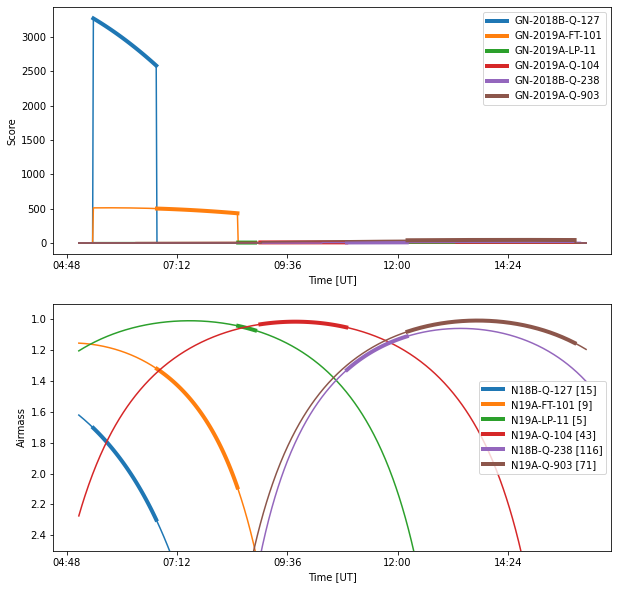

In [129]:
# Define variants for which to make plans

#  Times to block out - needs to depend on site and conditions/variant
time_blocks = [Time(["2021-04-24 04:30:00", "2021-04-24 08:00:00"], format='iso', scale='utc')]

# Actual conditions variants - needs to be site-specific in the multi-site case
variants = {
#             'IQ20 CC50': {'iq': 0.2, 'cc': 0.5, 'wv': 1.0, 'wd': -1, 'ws': -1},
            'IQ70 CC50': {'iq': 0.7, 'cc': 0.5, 'wv': 1.0, 'wdir': 330.*u.deg, 'wsep': 40.*u.deg, 'wspd': 5.0*u.m/u.s, 'tb': time_blocks},
#             'IQ70 CC70': {'iq': 0.7, 'cc': 0.7, 'wv': 1.0, 'wdir': -1, 'wsep': 30.*u.deg, 'wspd': 0.0*u.m/u.s, 'tb': time_blocks}, 
#             'IQ85 CC50': {'iq': 0.85, 'cc': 0.5, 'wv': 1.0, 'wdir': -1, 'wsep': 30.0*u.deg, 'wspd': 0.0*u.m/u.s, 'tb': time_blocks}, 
#             'IQ85 CC70': {'iq': 0.85, 'cc': 0.7, 'wv': 1.0, 'wdir': -1, 'wsep': 30.0*u.deg, 'wspd': 0.0*u.m/u.s, 'tb': time_blocks},
#             'IQ85 CC80': {'iq': 1.0, 'cc': 0.8, 'wv': 1.0, 'wdir': -1, 'wsep': 30.0*u.deg, 'wspd': 0.0*u.m/u.s, 'tb': []}
            }

varnames = list(variants.copy().keys())

# Logfile
# logfile = plandir + 'GM' + '_plans.txt'
# if os.path.isfile(logfile):
#     file_log = open(logfile, 'a')    
# else:
#     file_log = open(logfile, 'w')
#     print('#{:17} {:>6} {:>6} {:>10} {:>5} {:>5} {:>7} {:>8} {:>4}'.format('Obsid', 'Start', 'Stop', \
#           'MaxWeight', 'Cf0', 'Cf1', 'dmetric', 'Visfrac', 'iobs'), file=file_log)

# Use the QC plan for configurations
# Installed instruments - add visitor instruments manually for now
isntavail = {}
instavail = {ssite.lower(): qcplan.facilities['inst'].copy()}
instavail[ssite.lower()].extend(['IGRINS'])
print(instavail)

# Installed GMOS gratings
gmosdisp = {}
gmosdisp = {ssite.lower(): qcplan.facilities['gmosdisp'].copy()}
print(gmosdisp)

# Installed GMOS FPUs
gmosfpu = {}
gmosfpu = {ssite.lower(): qcplan.facilities['gmosfpu'].copy()}
gmosfpu[ssite.lower()] += qcplan.ictd['masks'].copy()
print(gmosfpu)

i_night = 0

qcvars = []
# Loop over variants
for varname in varnames:
    print(varname)
    print('   ', variants[varname]['iq'], variants[varname]['cc'], variants[varname]['wv'])

    # Actual (plan) conditions
    actcond = {ssite.lower(): {'iq': variants[varname]['iq'], 'cc': variants[varname]['cc'],
                               'wv': variants[varname]['wv'], 'wdir': variants[varname]['wdir'],
                               'wsep': variants[varname]['wsep'], 'wspd': variants[varname]['wspd'],
                               'tb': variants[varname]['tb']}
              }

    # Select observations that match the currrent (actual) conditions
#         iselo, progtab_orig, obstab_orig, targtab_orig = database.sched_tables(actcond, instavail, \
#                                                                               gmosdisp, gmosfpu, \
#                                                                               params9, 2)
    isel, progtab_plan, grptab_plan, targtab_plan, obstab_plan = database.schedgroups_select(actcond, instavail, \
                                                                    gmosdisp, gmosfpu, \
                                                                    params9, 2, inight=i_night, verbose=False)
    print(targtab_plan.colnames)
    
    file2 = open('target', 'wb')
    pickle.dump(targtab_plan,file2)
    file2.close()
    print(obstab_plan.colnames)
    file2 = open('obs', 'wb')
    pickle.dump(obstab_plan,file2)
    file2.close()
    print(grptab_plan.colnames)
    file2 = open('group', 'wb')
    pickle.dump(grptab_plan,file2)
    file2.close()

    nsel = len(isel)  
    print(nsel, 'observations selected.')

    # Analyze and print current plan
    # sites = list(plan.copy().keys())
    ssites = [ssite.lower()]

    for s in ssites:
        night_length = database.night_events[s]['night_length'][i_night]
#             print(night_length)

        # Run greedy-max
        plan, grptab, targtab, obstab = greedymax.schedule_night_multigrp(grptab_plan, targtab_plan, obstab_plan,
                                                        sites=[s], verbose=False)
#         print(plan)

        grp_order, i_start, i_end = greedymax._get_order(plan=plan[s]['grp'])
#         print(grp_order)
#         print(obs_order)
#             print(i_start)
#             print(i_end)
#             sum_score = 0.0
#             sum_metric = 0.0
        scitime = 0.0 * u.hr
        caltime = 0.0 * u.hr
        time_used = 0.0 * u.hr

#             # plot
#         fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
#         date_hhmm = dates.DateFormatter('%H:%M')
#             ax1.xaxis.set_major_formatter(date_hhmm)
#         ax2.xaxis.set_major_formatter(date_hhmm)

        for i in range(len(grp_order)):
            if grp_order[i] >= 0:
                # Time scheduled
                nt = (i_end[i] - i_start[i] + 1)
                tgrp =  nt * database.dt

                grp = grptab['obs_id'][grp_order[i]]
                # Time remaining [min]
                tremain_min = 60. * (grptab['tot_time'][grp_order[i]] - grptab['obs_time'][grp_order[i]])
#                 print('{:>6} {:>6} {:>7.3f} {:} {:}'.format(database.times[i_night][i_start[i]].strftime('%H:%M'), 
#                      database.times[i_night][i_end[i]].strftime('%H:%M'), 
#                      np.max(abs(targtab_plan['weight_'+s][obs_order[i]][i_start[i]:i_end[i]+1])),
#                      grptab['prog_ref'][obs_order[i]], database.schedgroups[grp]['name']))
                # Add dt to the end time since the timestamp is defined to be at the start of the step,
                # so the group will finish at the end of the step.
                print('{:>6} {:>6} {:>7.3f} {:} {:>7.1f}'.format(database.times[i_night][i_start[i]].strftime('%H:%M'), 
                     (database.times[i_night][i_end[i]] + database.dt).strftime('%H:%M'), 
                     np.max(abs(targtab_plan['weight_'+s][grp_order[i]][i_start[i]:i_end[i]+1])),
                     grptab['prog_ref'][grp_order[i]], tremain_min))
                
#                 print(abs(targtab_plan['weight_'+s][obs_order[i]][i_start[i]:i_end[i]+1]))
                
                # Observations
                # from obstab
#                 print(plan[s]['obs'][i_start[i]:i_end[i]+1])
                obs_order, o_start, o_end = greedymax._get_order(plan=plan[s]['obs'][i_start[i]:i_end[i]+1])
#                 print(obs_order)
#                 print(o_start)
#                 print(o_end)
                for j in range(len(obs_order)):
                    if obs_order[j] >= 0:
                        idx = obstab['idx'][obs_order[j]]
                        xmean = np.mean(obstab['airmass_' + s][obs_order[j]][i_start[i] + o_start[j]:i_start[i] + o_end[j] + 1])
                        print('   {:4d} {:18} {:12} {:15} {:10} {:4.2f} {:4.2f} {:5.2f}'.format(idx, 
                                                odbutils.shortid(obstab['obs_id'][obs_order[j]]), 
                                                obstab['obsclass'][obs_order[j]], database.target_name[idx], 
                                                database.instconfig[idx]['inst'],
                                                database.conditions[idx]['iq'], database.conditions[idx]['cc'],
                                                xmean))
                
                # Analyze partner cals
                iptr = database.schedgroups[grp]['iptr']


                time_used += tgrp

            print('') 

        print('Time scheduled = {:5.2f}'.format(time_used))
        print('Fraction of night scheduled = {:5.2f}'.format((time_used / night_length).value))
        print('')

#             # plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

        date_hhmm = dates.DateFormatter('%H:%M')
        ax1.xaxis.set_major_formatter(date_hhmm)
        ax2.xaxis.set_major_formatter(date_hhmm)

        # Groups
        for i in range(len(grp_order)):
            if grp_order[i] >= 0:
                p = ax1.plot(database.times[i_night].plot_date, abs(targtab['weight_'+s][grp_order[i]]))
                # https://stackoverflow.com/questions/36699155/how-to-get-color-of-most-recent-plotted-line-in-pythons-plt
                colour = p[-1].get_color()        
                ax1.plot(database.times[i_night][i_start[i]:i_end[i]+1].plot_date, abs(targtab['weight_'+s][grp_order[i]][i_start[i]:i_end[i]+1]), 
                        linewidth=4, color=colour, label=(grptab['prog_ref'][grp_order[i]]))
        
        obs_order, o_start, o_end = greedymax._get_order(plan=plan[s]['obs'])
        # Observations
        for i in range(len(obs_order)):
            if obs_order[i] >= 0:
                p = ax2.plot(database.times[i_night].plot_date, obstab['airmass_'+s][obs_order[i]])
                colour = p[-1].get_color()        
                ax2.plot(database.times[i_night][o_start[i]:o_end[i]+1].plot_date, obstab['airmass_'+s][obs_order[i]][o_start[i]:o_end[i]+1], 
                        linewidth=4, color=colour, label=odbutils.shortid(obstab_plan['obs_id'][obs_order[i]]))

        ax1.legend()
        ax2.legend()
        ax2.set_ylim(2.5, 0.9)

        ax1.set_xlabel('Time [UT]')
        ax2.set_xlabel('Time [UT]')

        ax1.set_ylabel('Score')
        ax2.set_ylabel('Airmass')

#             plt.savefig(plandir + date + '_GM_' + varname.replace(' ','') + '.png')
        plt.show()
# file_log.close()  
print('')

In [130]:
print(targtab_plan)

                 id                        weight_gn [663]      
------------------------------------ ---------------------------
5052b18e-af28-4293-a361-7384b347bd24                  0.0 .. 0.0
735eb791-181a-4415-b8cf-f178dfae1b0c                  0.0 .. 0.0
07c38595-be23-4f9a-9a19-77ec3f7389c0                  0.0 .. 0.0
4d69ee77-79d0-4564-a8c7-905b10dc5145                  0.0 .. 0.0
da31dd83-63db-40dd-b5db-9152a45cb908                  0.0 .. 0.0
16d2bd6e-67b4-4fb6-b68f-2d68c3bac2aa                  0.0 .. 0.0
ffb28bde-421f-4a8b-a550-30e7c7eb73e2                  0.0 .. 0.0
b3b446a2-0ee2-4846-b951-156168fe5096    0.0 .. 5.174218818656654
d19e5050-1551-42ce-a269-260dfd87642f    93.85273136982669 .. 0.0
6b2e221b-cc57-4f7e-9697-65fa81f21797    0.0 .. 6.165719897417059
                                 ...                         ...
6b1f32da-9ed3-4da0-b802-462a80a11636 0.0 .. 0.005524660666897696
3c2dafad-5ebf-4d89-bd60-a61c24b7b290 0.0 .. 0.005182008685941446
917dac91-7ef4-4bb6-815c-c

In [ ]:
inight = 0
print(database.ha[site_name][0][inight][0].value)

In [ ]:
print(database.targaz['gs'][181][0].to(u.deg))

In [ ]:
print(windconditions(330.*u.deg, 15.0*u.m/u.s, database.targaz['gs'][181][0]))

In [ ]:
# print(grptab_plan['split'][98], grptab_plan['obs_id'][98])
# score = targtab['weight_gs'][98].data
# # print(score)
# gid = grptab_plan['obs_id'][98]
# print(database.schedgroups[gid]['name'])
# print(database.schedgroups[gid]['split'])
# for idx in database.schedgroups[gid]['idx']:
#     print(database.obsid[idx])
# database.schedgroups[gid]['split'] = False

In [ ]:
grptab.show_in_notebook()

In [ ]:
gdx = np.where(grptab_plan['prog_ref'] == 'GS-2021A-Q-303')[0][:]
print(gdx)
# TODO: get observations from the following in the plans - the conditions for the variant were wrong
gdx = np.where(grptab_plan['prog_ref'] == 'GS-2021A-FT-208')[0][:]
print(gdx)
gdx = np.where(grptab_plan['prog_ref'] == 'GS-2021A-Q-209')[0][:]
print(gdx)

In [ ]:
print(grptab['prog_ref'][63], grptab['obs_id'][63], grptab['tot_time'][63] * 60., grptab['obs_time'][63])

In [ ]:
print(grptab_plan.colnames)
for grp in grptab_plan:
    print(grp['oidx'])

In [ ]:
targtab_plan.show_in_notebook()

In [ ]:
obstab.show_in_notebook()